In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#upload dataset
df = pd.read_csv("/content/drive/MyDrive/Pokemon.csv")

stats_columns = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
df[['Type 1', 'Type 2']] = df[['Type 1', 'Type 2']].fillna('None')

# One-hot encode types
encoder = OneHotEncoder(sparse_output=False)
type_encoded = encoder.fit_transform(df[['Type 1', 'Type 2']])

# Normalize stats
scaler = MinMaxScaler()
stats_scaled = scaler.fit_transform(df[stats_columns])

# Combine all features
features = np.hstack([stats_scaled, type_encoded])

In [2]:
#Define VAE

input_dim = features.shape[1]

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [3]:
#Train the VAE

X_tensor = torch.tensor(features, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

vae = VAE(input_dim=input_dim)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

def loss_fn(x_recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

losses = []
for epoch in range(50):
    total = 0
    for (x,) in loader:
        x_recon, mu, logvar = vae(x)
        loss = loss_fn(x_recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()
    losses.append(total)
    print(f"Epoch {epoch+1}, Loss: {total:.2f}")


Epoch 1, Loss: 7097.55
Epoch 2, Loss: 5266.57
Epoch 3, Loss: 3112.29
Epoch 4, Loss: 2024.60
Epoch 5, Loss: 1660.75
Epoch 6, Loss: 1553.79
Epoch 7, Loss: 1509.39
Epoch 8, Loss: 1485.72
Epoch 9, Loss: 1472.02
Epoch 10, Loss: 1467.25
Epoch 11, Loss: 1465.12
Epoch 12, Loss: 1462.82
Epoch 13, Loss: 1460.98
Epoch 14, Loss: 1456.36
Epoch 15, Loss: 1456.42
Epoch 16, Loss: 1458.24
Epoch 17, Loss: 1454.09
Epoch 18, Loss: 1456.85
Epoch 19, Loss: 1454.93
Epoch 20, Loss: 1453.46
Epoch 21, Loss: 1454.21
Epoch 22, Loss: 1452.91
Epoch 23, Loss: 1451.97
Epoch 24, Loss: 1452.56
Epoch 25, Loss: 1452.08
Epoch 26, Loss: 1450.58
Epoch 27, Loss: 1450.10
Epoch 28, Loss: 1451.02
Epoch 29, Loss: 1450.42
Epoch 30, Loss: 1450.69
Epoch 31, Loss: 1448.61
Epoch 32, Loss: 1448.20
Epoch 33, Loss: 1449.44
Epoch 34, Loss: 1451.53
Epoch 35, Loss: 1448.97
Epoch 36, Loss: 1448.85
Epoch 37, Loss: 1447.18
Epoch 38, Loss: 1448.74
Epoch 39, Loss: 1448.41
Epoch 40, Loss: 1448.43
Epoch 41, Loss: 1447.99
Epoch 42, Loss: 1448.51
E

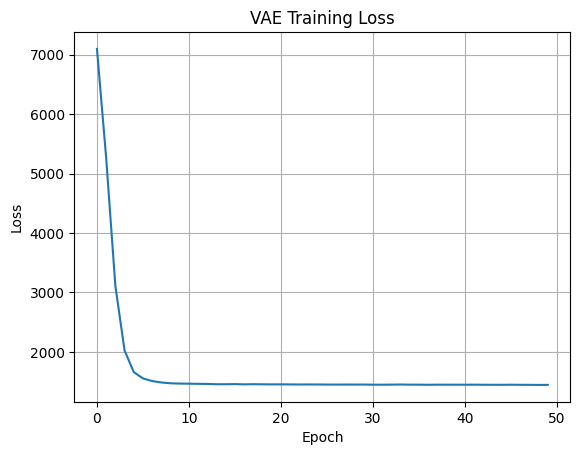

In [4]:
#Visualize Training Loss

import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [5]:
#Generate New Pokémon

vae.eval()
with torch.no_grad():
    z = torch.randn(100, 2)
    outputs = vae.decoder(z).numpy()

# Split stats and type encodings
generated_stats = scaler.inverse_transform(outputs[:, :6])
generated_types = encoder.inverse_transform(outputs[:, 6:])

# Combine into DataFrame
gen_df = pd.DataFrame(generated_stats, columns=stats_columns)
gen_df[['Type 1', 'Type 2']] = generated_types
print(gen_df.round(1))


           HP     Attack    Defense    Sp. Atk    Sp. Def      Speed  Type 1  \
0   71.199997  79.000000  71.099998  74.400002  71.699997  70.099998  Normal   
1   68.300003  80.599998  74.500000  74.900002  74.800003  67.500000   Water   
2   68.099998  79.199997  73.199997  74.500000  71.300003  66.599998   Water   
3   67.500000  80.300003  75.099998  74.000000  73.199997  67.099998   Water   
4   69.699997  78.300003  76.500000  73.500000  68.800003  67.300003   Water   
..        ...        ...        ...        ...        ...        ...     ...   
95  70.199997  78.699997  74.400002  76.699997  75.500000  69.199997   Water   
96  67.599998  80.500000  73.099998  75.099998  73.800003  66.500000   Water   
97  69.300003  80.599998  76.300003  75.599998  72.500000  68.099998   Water   
98  71.500000  80.300003  75.599998  75.699997  75.000000  69.400002   Water   
99  70.800003  81.000000  77.199997  77.199997  75.400002  69.400002   Water   

   Type 2  
0    None  
1    None  
2  

In [6]:
#Simple Battle Simulation

import random

# Simplified Type Chart (expandable)
type_chart = {
    'Fire': {'Grass': 2.0, 'Water': 0.5, 'Fire': 0.5},
    'Water': {'Fire': 2.0, 'Grass': 0.5, 'Water': 0.5},
    'Grass': {'Water': 2.0, 'Fire': 0.5, 'Grass': 0.5}
}

def get_multiplier(attacker, defender):
    return type_chart.get(attacker, {}).get(defender, 1.0)

def simulate_battle(poke1, poke2):
    atk1, def2 = poke1['Attack'], poke2['Defense']
    atk2, def1 = poke2['Attack'], poke1['Defense']

    mult1 = get_multiplier(poke1['Type 1'], poke2['Type 1'])
    mult2 = get_multiplier(poke2['Type 1'], poke1['Type 1'])

    score1 = atk1 * mult1 - def2
    score2 = atk2 * mult2 - def1

    if score1 > score2:
        return "Generated"
    elif score2 > score1:
        return "Real"
    else:
        return "Draw"


In [7]:
#Simulate 100 Battles to Evaluate Model

df['Type 2'] = df['Type 2'].fillna('None')

# import numpy as np
# gen_df = pd.DataFrame({
#     'Attack': np.random.randint(40, 120, size=100),
#     'Defense': np.random.randint(30, 100, size=100),
#     'Type 1': np.random.choice(['Fire', 'Water', 'Grass'], size=100),
#     'Type 2': ['None']*100
# })

# Initialize counters
results = {'Generated': 0, 'Real': 0, 'Draw': 0}


for _, gen_poke in gen_df.iterrows():
    real_poke = df.sample(1).iloc[0]
    poke1 = {
        'Attack': gen_poke['Attack'],
        'Defense': gen_poke['Defense'],
        'Type 1': gen_poke['Type 1'],
        'Type 2': gen_poke['Type 2']
    }
    poke2 = {
        'Attack': real_poke['Attack'],
        'Defense': real_poke['Defense'],
        'Type 1': real_poke['Type 1'],
        'Type 2': real_poke['Type 2']
    }

    result = simulate_battle(poke1, poke2)
    results[result] += 1

# Final validation report
total = sum(results.values())
print(f"Validation Results (out of {total} battles):")
print(f"Generated Pokémon Wins: {results['Generated']} ({results['Generated']/total:.2%})")
print(f"Real Pokémon Wins:      {results['Real']} ({results['Real']/total:.2%})")
print(f"Draws:                  {results['Draw']} ({results['Draw']/total:.2%})")


Validation Results (out of 100 battles):
Generated Pokémon Wins: 44 (44.00%)
Real Pokémon Wins:      56 (56.00%)
Draws:                  0 (0.00%)


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar(stats, title='Pokémon Stats Radar'):
    labels = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
    values = stats.tolist()
    values += values[:1]  # close the circle

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid', color='blue')
    ax.fill(angles, values, alpha=0.25, color='skyblue')

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, size=15, y=1.1)
    plt.show()


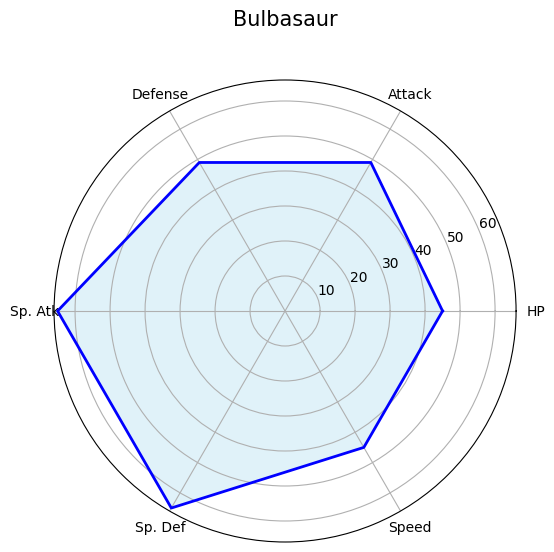

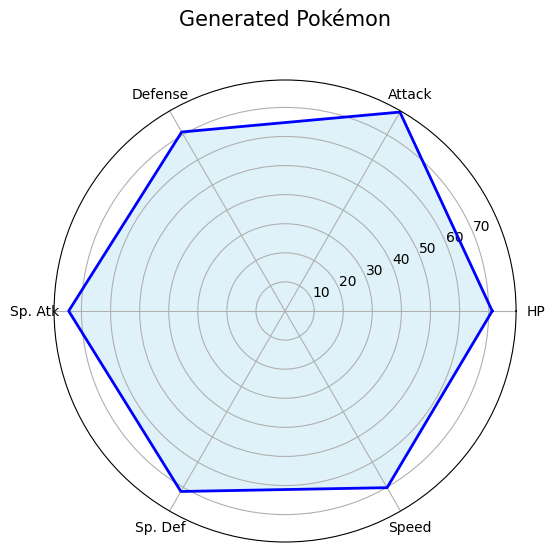

In [9]:
# Plot a real Pokémon
plot_radar(df[stats_columns].iloc[0].values, title=df['Name'].iloc[0])

# Plot a generated Pokémon
plot_radar(generated_stats[0], title='Generated Pokémon')
